# Testing IsoForest baseline on Kyoto-2006+ data


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve

pd.options.mode.chained_assignment = None 

In [3]:
def load_train_year(year):
    if year <= 2010:
        df = pd.read_parquet(f'../datasets/Kyoto-2016_AnoShift/subset/{year}_subset.parquet',  engine='fastparquet')
    else:
        import sys
        sys.exit(-1)
    df = df.reset_index(drop=True)
    return df

def load_test_year(year):
    if year <= 2010:
        df = pd.read_parquet(f'../datasets/Kyoto-2016_AnoShift/subset/{year}_subset_valid.parquet',  engine='fastparquet')
    else:
        df = pd.read_parquet(f'../datasets/Kyoto-2016_AnoShift/subset/{year}_subset.parquet',  engine='fastparquet')

    df = df.reset_index(drop=True)
    return df


def rename_columns(df):    
    categorical_cols = ["0", "1", "2", "3", "13"]
    numerical_cols = ["4", "5", "6", "7", "8", "9", "10", "11", "12"]
    additional_cols = ["14", "15", "16", "17", "19"]
    label_col = ["18"]

    new_names = []
    for col_name in df.columns.astype(str).values:
        if col_name in numerical_cols:
            df[col_name] = pd.to_numeric(df[col_name])
            new_names.append((col_name, "num_" + col_name))
        elif col_name in categorical_cols:
            new_names.append((col_name, "cat_" + col_name))
        elif col_name in additional_cols:
            new_names.append((col_name, "bonus_" + col_name))
        elif col_name in label_col:
            df[col_name] = pd.to_numeric(df[col_name])
            new_names.append((col_name, "label"))
        else:
            new_names.append((col_name, col_name))
    df.rename(columns=dict(new_names), inplace=True)
    
    return df

def preprocess(df, enc=None):
    if not enc:
        enc = OneHotEncoder(handle_unknown='ignore')
        enc.fit(df.loc[:,['cat_' in i for i in df.columns]])
    
    num_cat_features = enc.transform(df.loc[:,['cat_' in i for i in df.columns]]).toarray()

    df_catnum = pd.DataFrame(num_cat_features)
    df_catnum = df_catnum.add_prefix('catnum_')

    df.reset_index(drop=True)
    df_new = pd.concat([df,  df_catnum], axis=1)
    
    
    filter_clear = df_new["label"] == 1
    filter_infected = df_new["label"] < 0
    df_new["label"][filter_clear] = 0
    df_new["label"][filter_infected] = 1

    return df_new, enc


def print_results(labels, preds, text="?", normalize="true", th=0.5):
    precision_anom, recall_anom, th_anom = precision_recall_curve(labels, preds, pos_label=1)
    precision_norm, recall_norm, th_norm = precision_recall_curve(labels, 1-np.array(preds), pos_label=0)
    
    prec, recall, _, _ = precision_recall_fscore_support(labels, np.array(preds)>=th)
    
    # Use AUC function to calculate the area under the curve of precision recall curve
    pr_auc_norm = auc(recall_norm, precision_norm)
    pr_auc_anom = auc(recall_anom, precision_anom)
    
    roc_auc = roc_auc_score(labels, preds)
    
    print("[%s] ROC-AUC     %.2f%% | PR-AUC-norm    %.2f%% | PR-AUC-anom    %.2f%%" % (text, roc_auc*100, pr_auc_norm*100, pr_auc_anom*100))
    return roc_auc*100, pr_auc_norm*100, pr_auc_anom*100

In [4]:
def get_train(train_years):
    dfs = []

    for year in train_years:
        df_year = load_train_year(year)
        count_norm = df_year[df_year["18"] == "1"].shape[0]
        count_anomal = df_year[df_year["18"] != "1"].shape[0]
        print(year, "normal:", count_norm, "anomalies:", count_anomal)
        dfs.append(df_year)
    
    print("Preprocess train data...")
    df_all_years = pd.concat(dfs, ignore_index=True)
    df_all_years = rename_columns(df_all_years)
    df_new, ohe_enc = preprocess(df_all_years)

    # split train + val
    X_train, X_val = train_test_split(df_new, test_size=0.001, random_state=0, shuffle=True)

    # select numerical features
    numerical_cols = df_new.columns.to_numpy()[['num_' in i for i in df_new.columns]]

    X_train_clear = X_train[X_train["label"] == 0]
    X_train_num = X_train_clear[numerical_cols].to_numpy()

    X_val_num = X_val[numerical_cols].to_numpy()
    y_val_num = X_val["label"].to_numpy()
    return X_train_num, X_val_num, y_val_num, numerical_cols, ohe_enc

In [5]:
pair_years = []
pair_years.append(([2006, 2007, 2008, 2009, 2010], [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]))

    
for train_years, test_years in pair_years:
    rocs, pr_norms, pr_anoms = [], [], []
    print("Train_years:", train_years)
    X_train_num, X_val_num, y_val_num, numerical_cols, ohe_enc = get_train(train_years)
    print("Fit IsolationForest...")
    clf = IsolationForest(random_state=42,
                      n_estimators=101,
                      max_samples=1.0,
                      max_features=1.0,
                      verbose=1,
                      n_jobs=10)
    clf.fit(X_train_num)

    del X_train_num
    print("Done fitting.")
    
    print("Test years:", test_years)
    for year in test_years:
        df_year = load_test_year(year)
        df_year = rename_columns(df_year)
        df_test, _ = preprocess(df_year, ohe_enc)
        X_test = df_test[numerical_cols].to_numpy()
        y_test = df_test["label"].to_numpy()

        X_test = np.nan_to_num(X_test)
        predict_test = (-1) * clf.score_samples(X_test)
        predict_test = np.nan_to_num(predict_test, 0)
        y_test = np.nan_to_num(y_test, 0)
        roc, pr_norm, pr_anom = print_results(y_test, predict_test, text=str(year), normalize=None, th=0.35)
        rocs.append(roc)
        pr_norms.append(pr_norm)
        pr_anoms.append(pr_anom)
        del df_test, df_year, X_test


Train_years: [2006, 2007, 2008, 2009, 2010]
2006 normal: 50000 anomalies: 416774
2007 normal: 300000 anomalies: 115471
2008 normal: 300000 anomalies: 74713
2009 normal: 300000 anomalies: 109403
2010 normal: 300000 anomalies: 261262
Preprocess train data...
Fit IsolationForest...


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:  1.4min remaining:  5.6min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  1.6min finished


Done fitting.
Test years: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
[2006] ROC-AUC     75.75% | PR-AUC-norm    26.65% | PR-AUC-anom    96.10%
[2007] ROC-AUC     93.45% | PR-AUC-norm    97.22% | PR-AUC-anom    85.85%
[2008] ROC-AUC     95.62% | PR-AUC-norm    98.75% | PR-AUC-anom    87.49%
[2009] ROC-AUC     85.72% | PR-AUC-norm    92.97% | PR-AUC-anom    74.55%
[2010] ROC-AUC     80.28% | PR-AUC-norm    80.97% | PR-AUC-anom    80.02%
[2011] ROC-AUC     72.05% | PR-AUC-norm    45.12% | PR-AUC-anom    87.55%
[2012] ROC-AUC     64.73% | PR-AUC-norm    49.49% | PR-AUC-anom    80.22%
[2013] ROC-AUC     66.25% | PR-AUC-norm    35.85% | PR-AUC-anom    88.44%
[2014] ROC-AUC     20.82% | PR-AUC-norm    8.63% | PR-AUC-anom    77.37%
[2015] ROC-AUC     21.39% | PR-AUC-norm    8.71% | PR-AUC-anom    76.89%


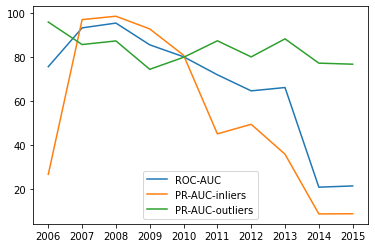

In [6]:
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.plot(test_years, rocs, label='ROC-AUC')
plt.plot(test_years, pr_norms, label='PR-AUC-inliers')
plt.plot(test_years, pr_anoms, label='PR-AUC-outliers')
plt.legend()
plt.show()